# Imports

In [1]:
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
from helpers import (
    _augment_with_reverse_mutation,
    _populate_dfs_with_nlls_and_nlfs,
    _populate_dfs_with_resenvs,
    _train_loop,
    _train_val_split,
    _get_ddg_training_dataloaders,
    _get_ddg_validation_dataloaders,
    _train_downstream_and_evaluate,
)
from visualization import scatter_pred_vs_true, plot_validation_performance

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# Hack to find the conda activate path since bash scripts
# don't necessarily work with the conda activate command
conda_path = !which conda
conda_path = list(conda_path)[0]
conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
if not conda_activate_path.is_file():
    raise FileNotFoundError(
        "Could not find your conda activate path needed for running bash scripts."
    )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 2
PATIENCE_CUTOFF = 1
EPS = 1e-9

# Parameters specific to downstream model
BATCH_SIZE_DDG = 40
SHUFFLE_DDG = True
LEARNING_RATE_DDG = 1e-3
EPOCHS_DDG = 200

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [5]:
parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
if SHUFFLE_PDBS:
    random.shuffle(parsed_pdb_filenames)
dataloader_train, dataset_train, dataloader_val, dataset_val = _train_val_split(
    parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
)

Training data set includes 7 pdbs with 2993 environments.
Validation data set includes 2 pdbs with 326 environments.


<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
# Define model
cavity_model_net = CavityModel(DEVICE).to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

# Create directory for model files
models_dirpath = "cavity_models/"
if not os.path.exists(models_dirpath):
    os.mkdir(models_dirpath)

# Train loop
best_model_path = _train_loop(
    dataloader_train,
    dataloader_val,
    cavity_model_net,
    loss_function,
    optimizer,
    EPOCHS,
    PATIENCE_CUTOFF,
)

Epoch  0. Train loss: 2.751. Train Acc: 0.21. Val loss: 3.186. Val Acc 0.04
Epoch  1. Train loss: 1.498. Train Acc: 0.74. Val loss: 3.061. Val Acc 0.09
Best epoch idx: 1 with validation loss: 3.061 and model_path: cavity_models/model_epoch_01.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [7]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [8]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [9]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [10]:
_populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [11]:
# Load best performing cavity model from previos training
cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

_populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS
)

<IPython.core.display.Javascript object>

## Results without downstream model

### Plot with PDB statistics

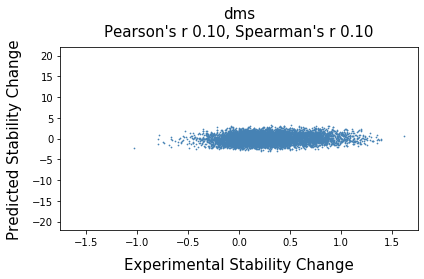

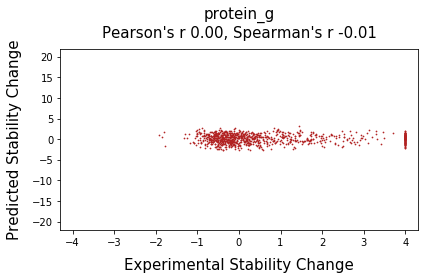

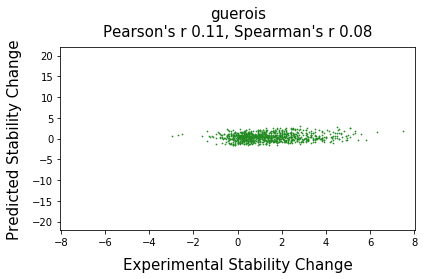

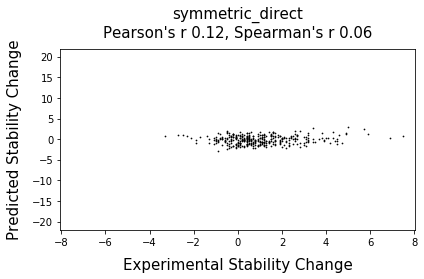

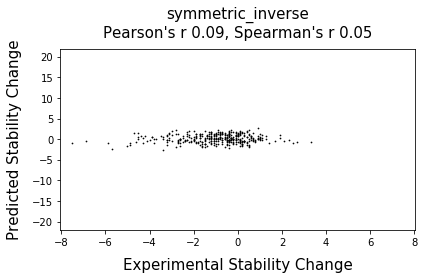

<IPython.core.display.Javascript object>

In [12]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

### Plot with IDP statistics

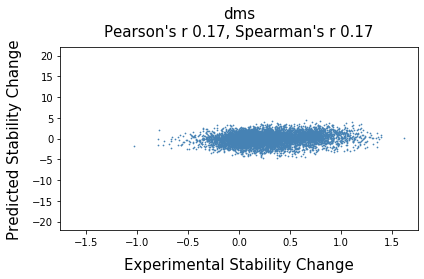

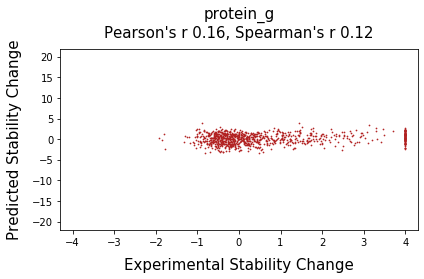

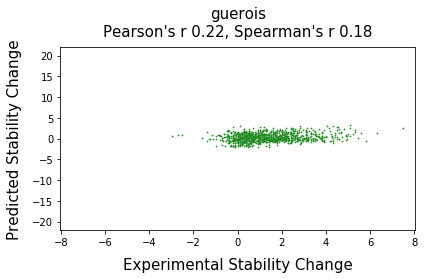

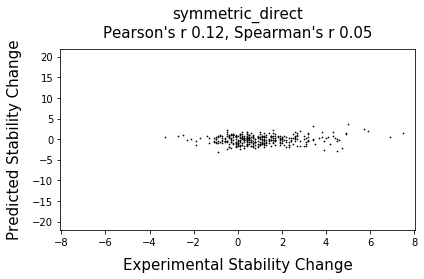

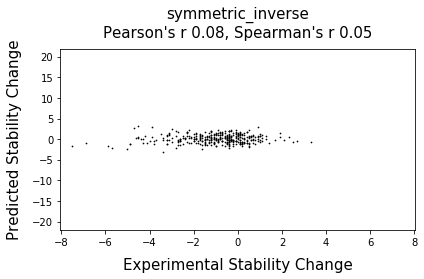

<IPython.core.display.Javascript object>

In [13]:
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_idp_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [14]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both structures

In [15]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

In [16]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_idp_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_dir"] - row["ddg_pred_idp_no_ds_inv"]),
    axis=1,
)
symmetric_both_df["ddg_pred_idp_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_inv"] - row["ddg_pred_idp_no_ds_dir"]),
    axis=1,
)

<IPython.core.display.Javascript object>

### Plot prediction using both structures

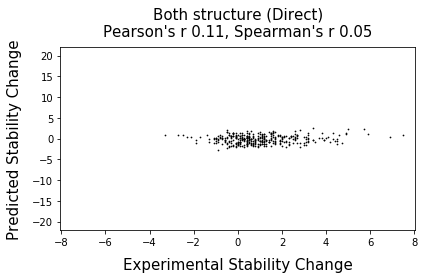

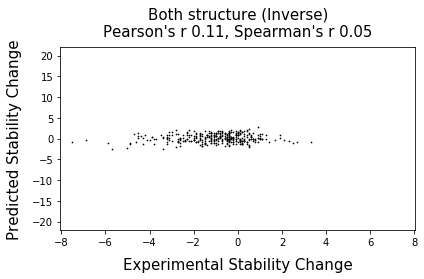

<IPython.core.display.Javascript object>

In [17]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Plot prediction using both structures (IDP statistics)

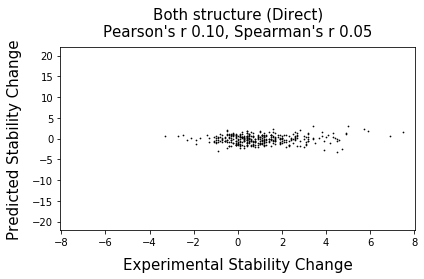

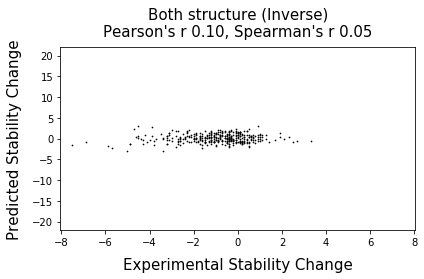

<IPython.core.display.Javascript object>

In [18]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

Add sequence fragments to df

In [19]:
from helpers import _add_flanking_seq_fragments

# Add flanking sequence fragments for protein g
raw_pdbs = glob.glob("data/data_protein_g/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    _add_flanking_seq_fragments(
        ddg_data_dict,
        "protein_g",
        raw_pdb,
    )

<IPython.core.display.Javascript object>

In [29]:
ddg_data_dict["protein_g"].head(100)

,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds,wt_idp_nlf,mt_idp_nlf,ddg_pred_idp_no_ds,left_flank,wt_restype,right_flank
0,1PGA,A,M1A,-0.1407,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,0,"[2.8289661, 3.739578, 2.4844475, 1.9753343, 3....",3.159795,2.828966,3.785957,2.483982,0.971145,3.974215,2.679916,0.963470,-----,M,TYKLI
1,1PGA,A,M1D,-0.3795,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,2,"[2.8289661, 3.739578, 2.4844475, 1.9753343, 3....",3.159795,2.484447,3.785957,2.824680,0.285929,3.974215,2.836449,0.462418,-----,M,TYKLI
2,1PGA,A,M1E,-0.6414,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,3,"[2.8289661, 3.739578, 2.4844475, 1.9753343, 3....",3.159795,1.975334,3.785957,2.712832,-0.111337,3.974215,2.405165,0.384589,-----,M,TYKLI
3,1PGA,A,M1L,-0.4573,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,9,"[2.8289661, 3.739578, 2.4844475, 1.9753343, 3....",3.159795,3.433893,3.785957,2.433114,1.626941,3.974215,2.544290,1.704022,-----,M,TYKLI
4,1PGA,A,T2E,-0.1299,<ResidueEnvironment with 157 atoms. pdb_id: 1P...,16,3,"[2.9362104, 3.69632, 2.5221348, 2.2472389, 3.4...",2.583930,2.247239,2.896883,2.712832,-0.152641,2.861809,2.405165,0.119953,----M,T,YKLIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1PGA,A,L12E,0.2471,<ResidueEnvironment with 143 atoms. pdb_id: 1P...,9,3,"[3.053101, 3.663936, 2.8426945, 2.2082553, 3.2...",3.443662,2.208255,2.433114,2.712832,-1.515125,2.544290,2.405165,-1.096281,LNGKT,L,KGETT
96,1PGA,A,L12G,0.2833,<ResidueEnvironment with 143 atoms. pdb_id: 1P...,9,5,"[3.053101, 3.663936, 2.8426945, 2.2082553, 3.2...",3.443662,4.166174,2.433114,2.560213,0.595413,2.544290,2.728920,0.537882,LNGKT,L,KGETT
97,1PGA,A,L12H,-0.2832,<ResidueEnvironment with 143 atoms. pdb_id: 1P...,9,6,"[3.053101, 3.663936, 2.8426945, 2.2082553, 3.2...",3.443662,4.073808,2.433114,3.772712,-0.709453,2.544290,4.641654,-1.467218,LNGKT,L,KGETT
98,1PGA,A,L12I,-0.9906,<ResidueEnvironment with 143 atoms. pdb_id: 1P...,9,7,"[3.053101, 3.663936, 2.8426945, 2.2082553, 3.2...",3.443662,3.603081,2.433114,2.854018,-0.261485,2.544290,3.190861,-0.487151,LNGKT,L,KGETT


<IPython.core.display.Javascript object>

# Downstream model

### Performance without augmentation

Define training dataloader and eval dataloaders

In [21]:
# ddg_dataloaders_train_dict = _get_ddg_training_dataloaders(
#     ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG
# )
# ddg_dataloaders_val_dict = _get_ddg_validation_dataloaders(ddg_data_dict)

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [22]:
# pearsons_r_results_dict = _train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [23]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])

<IPython.core.display.Javascript object>

### Performance with augmentation

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [24]:
# ddg_data_dict_augmented = _augment_with_reverse_mutation(ddg_data_dict)

<IPython.core.display.Javascript object>

Define training dataloader (augmented data) and eval dataloaders (original data)

In [25]:
# ddg_dataloaders_train_dict = _get_ddg_training_dataloaders(
#     ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG
# )
# ddg_dataloaders_val_dict = _get_ddg_validation_dataloaders(ddg_data_dict)

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [26]:
# pearsons_r_results_dict = _train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

<IPython.core.display.Javascript object>

In [27]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])

<IPython.core.display.Javascript object>